In [1]:
# -------------------------------------------------------------------------------------------------------
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context('talk')

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre+'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dirPre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dirPre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SCP'  # Processed data directory

## Define Functions

In [ ]:
def gradRichardson(# input
                    airTemp,                # air temperature (K) corresponding to heights N
                    windSpd,                # wind speeds (m s^-1) corresponding to heights N
                    mHeight                 # measurement heights (m) of wind and air temperature
                    ):
    # -------------------------------------------------------------------------------------------------------
    # Sub-function
    def logGrad(x1,x2,z1,z2):
        # Log gradient function
        mid = np.exp((np.log(z1) + np.log(z2))/2)
        grad = 1/mid * ((x2 - x1)/(np.log(z2)-np.log(z1)))
        return grad,mid

    # -------------------------------------------------------------------------------------------------------
    # Algorithm
    
    #########
    # Constants/Parameters
    g = 9.81                                # gravitational acceleration (m s^-2)
    numL = mHeight.size                     # Number of layers
    
    #########
    # Difference each heigh using logGrad
    gradWind = np.zeros(numL-1)             # Gradient in wind
    zMid = np.zeros(numL-1)                 # Log-averaged height beetween layers
    gradTheta = np.zeros(numL-1)            # Gradient in virtual temperature
    thetaMid = np.zeros(numL-1)             # "virtual" temperature at the mid-point between levels
    
    for k in np.arange(0,numL-1):
        (grad_u[k],zm[k]) = logGrad(u[k],u[k+1],z[k],z[k+1])
        (grad_theta[k],zm[k]) = logGrad(theta[k],theta[k+1],z[k],z[k+1])
        theta_m[k] = np.exp((np.log(theta[k]) + np.log(theta[k+1]))/2)

    # Calculate the gradient Richardson Number
    gradRi = g/theta_m * (grad_theta/grad_u**2)
    gradRiMean = np.mean(gradRi)
    return(gradRi,gradRiMean)

In [2]:
# -------------------------------------------------------------------------------------------------------
# Open netcdfs
os.chdir(dirData)
Atower = xr.open_dataset('SCP.Atower.netcdf')
Ctower = xr.open_dataset('SCP.Ctower.netcdf')
Mtower = xr.open_dataset('SCP.Mtower.netcdf')
soilObs = xr.open_dataset('SCP.soil_obs.netcdf')
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

In [3]:
aggFlag = False
# -------------------------------------------------------------------------------------------------------
# Aggregate to half and hour
if aggFlag:
    # 30 minute averages of fluxes
    fluxObs_30m = fluxObs.resample(freq='30Min',how='mean',dim='time')
    radObs_30m = radObs.resample(freq='30Min',how='mean',dim='time')
    soilObs_30m = soilObs.resample(freq='30Min',how='mean',dim='time')

    # Mean ground heat flux @ both sites
    soilObs_30m['Gsfc'] = xr.concat([soilObs_30m.Gsfc_c,\
                                        soilObs_30m.Gsfc_g],dim='site').mean(dim='site')
    soilObs_30m['Gsoil_5cm'] = xr.concat([soilObs_30m.Gsoil_5cm_c,\
                                        soilObs_30m.Gsoil_5cm_g],dim='site').mean(dim='site')
    # Save 30min averages
    os.chdir(dirData)
    fluxObs_30m.to_netcdf('SCP.flux_obs_30m.netcdf')
    radObs_30m.to_netcdf('SCP.rad_obs_30m.netcdf')
    soilObs_30m.to_netcdf('SCP.soil_obs_30m.netcdf')
    
# -------------------------------------------------------------------------------------------------------
# Load 30min averages
elif not aggFlag:
    os.chdir(dirData)
    fluxObs_30m = xr.open_dataset('SCP.flux_obs_30m.netcdf')
    radObs_30m = xr.open_dataset('SCP.rad_obs_30m.netcdf')
    soilObs_30m = xr.open_dataset('SCP.soil_obs_30m.netcdf')

In [4]:
# -------------------------------------------------------------------------------------------------------
# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.                   # Stefan-Boltzmann constant
Tsfc = (radObs.Rlw_out/sigma)**(1./4.)

# Insert into Mtower xarray.Dataset
Mtower['Tsfc'] = (('time'), Tsfc-273.15)

# -------------------------------------------------------------------------------------------------------
# Bulk Richardson Number
Mtower['UBar_15m'] = (('time'), (Mtower.U_15m_M**2 + Mtower.V_15m_M**2)**(1. / 2.))
Mtower.UBar_15m[Mtower.UBar_15m > 10] = np.nan
Mtower['UBar_2m'] = (('time'), (Mtower.u_2m_M**2 + Mtower.v_2m_M**2)**(1. / 2.))
Mtower.UBar_15m[Mtower.UBar_2m > 10] = np.nan

RiBulk_15m, _, _ = turbpy.bulkRichardson(Mtower.T_15m_M + 273.15,
                                         Mtower.Tsfc + 273.15,
                                         Mtower.UBar_15m,
                                         15.,
                                        )
Mtower['RiBulk_15m'] = RiBulk_15m

RiBulk_2m, _, _ = turbpy.bulkRichardson(Mtower.T_1m_M + 273.15,
                                        Mtower.Tsfc + 273.15,
                                        Mtower.UBar_2m,
                                        2.,
                                       )
Mtower['RiBulk_2m'] = RiBulk_2m

In [ ]:
import turbpy
import turbpy.multiConst as mc
ixStability = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov')
nTime = Atower.time.size
nSta = Atower.station.size

stability = {
    ixStability[0]: np.ones((nSta, nTime)) * np.nan,
    ixStability[1]: np.ones((nSta, nTime)) * np.nan,
    ixStability[2]: np.ones((nSta, nTime)) * np.nan,
    ixStability[3]: np.ones((nSta, nTime)) * np.nan,
    }
conductanceSensible = {
    ixStability[0]: np.ones((nSta, nTime)) * np.nan,
    ixStability[1]: np.ones((nSta, nTime)) * np.nan,
    ixStability[2]: np.ones((nSta, nTime)) * np.nan,
    ixStability[3]: np.ones((nSta, nTime)) * np.nan,
    }

In [ ]:
for stab in ixStability:
    for nt, t in enumerate(Atower.time[0:400]):
        for ns, sta in enumerate(Atower.station):
            ds = Atower.sel(station=sta).sel(time=t)
            if ds['time.hour'] == 0 & ds['time.minute'] == 2:
                print(ds['time.month'] + '/' + ds['time.day'])
            airTemp = ds.T_0_5m + 273.15  # (C) -> (K)
            windSpd = ds.UBar_5m
            svp, _ = turbpy.conversionTools.satVapPress(airTemp)  # Saturation vapor pressure
            airVaporPress = svp * ds.RH_0_5m / 100.  # Vapor pressure (Pa)
            windspd = ds.UBar_5m
            sfcTemp = Mtower.Tsfc.sel(time=t) + 273.15  # (C) -> (K)
            sfcVaporPress, _ = turbpy.conversionTools.satVapPress(sfcTemp)
                        
            (_, stabOutput, _,
             conductanceSensible[stab][ns, nt], _) = turbpy.aStability(False, stab, mc.stabParams[stab], 5.,
                                                                       airTemp, airVaporPress, sfcTemp,
                                                                       sfcVaporPress, windSpd, 0.05)
            if not stab ==  'moninObukhov':
                stability[stab][ns, nt] = stabOutput['stabilityCorrection']

In [29]:
os.chdir(dirProj)
sensible_1m = xr.open_dataset('OfflineTurb.SCP.sensible_1m.ALL.nc')
sensible_15m = xr.open_dataset('OfflineTurb.SCP.sensible_15m.ALL.nc')
latent_1m = xr.open_dataset('OfflineTurb.SCP.latent_1m.ALL.nc')
latent_15m = xr.open_dataset('OfflineTurb.SCP.latent_15m.ALL.nc')

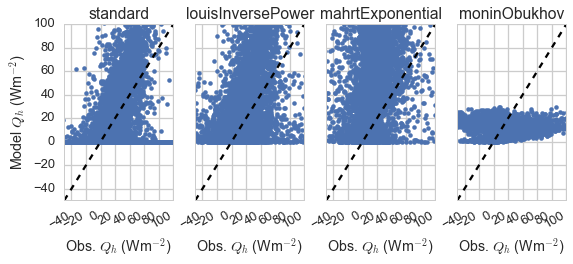

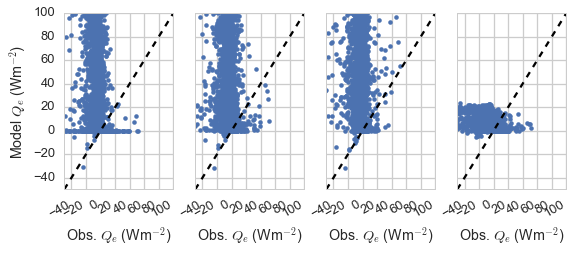

In [38]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(9,3.5))
Qmax = 100
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(-fluxObs.w_tc__10m_M[ind], sensible_15m[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

########
# Model Latent vs Obs Latent 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(9,3.5))
Qmax = 100
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(-fluxObs.w_h2o__10m_M[ind], latent_15m[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_e$ (Wm$^{-2}$)')
#     ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_e$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent.pdf')


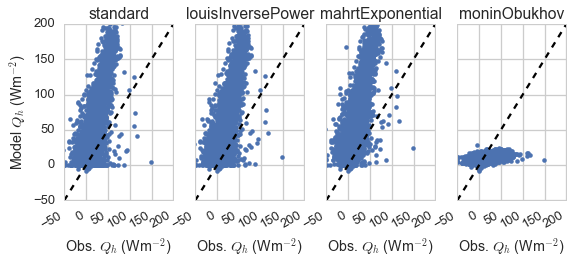

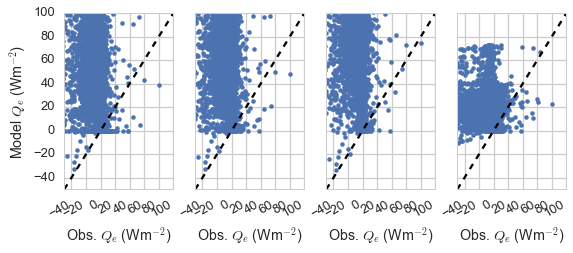

In [40]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(9,3.5))
Qmax = 200
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(-fluxObs.w_tc__2m_M[ind], sensible_1m[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

########
# Model Latent vs Obs Latent 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(9,3.5))
Qmax = 100
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(-fluxObs.w_h2o__2m_M[ind], latent_1m[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_e$ (Wm$^{-2}$)')
#     ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_e$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent.pdf')


IndexError: index 12064 is out of bounds for axis 1 with size 12045

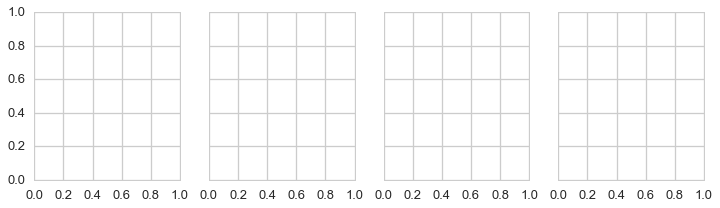

In [45]:
ind = np.nonzero( (Mtower.RiBulk_15m > 0.).values & (Mtower.UBar_2m > 2.).values)
os.chdir(dirPrint)
########
# Sensible
fig,axes = plt.subplots(1,4,sharey=True,figsize=(12,3))
Qmax = 200
Qmin = -200
RiMax = 4.
RiMin = -0.1

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Mtower.RiBulk_15m[ind], sensible_15m[stab][ind],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Mtower.RiBulk_15m[ind], \
        fluxObs.w_tc__10m_M[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()

########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,3,sharey=True,figsize=(9,3.5))
Qmax = 150
Qmin = -150

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(fluxObs.w_tc__10m_M[ind], sensible_15m[stab][ind],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

########
# Model Latent vs Obs Latent 
# os.chdir(dirPrint)
# fig,axes = plt.subplots(1,3,sharey=True,figsize=(9,3.5))
# Qmax = 100
# Qmin = -50

# for n,stab in enumerate(ixStability):
#     ax = axes[n]
#     ax.plot(fluxObs.w_h2o__10m_M[ind], latent[stab][ind],'.',label=stab)
#     ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
#     ax.set_ylim(Qmin,Qmax)
#     ax.set_xlim(Qmin,Qmax)
#     ax.set_xlabel('Obs. $Q_e$ (Wm$^{-2}$)')
# #     ax.set_title(stab)

# ax = axes[0]
# ax.set_ylabel('Model $Q_e$ (Wm$^{-2}$)')

# fig.autofmt_xdate()
# # fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent.pdf')
